Arielle and I collaborated on this code.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import copy

dig1 = 1
dig2 = 5

train = np.loadtxt("ZipDigits.train",delimiter=" ",usecols=range(0, 257))
test = np.loadtxt("ZipDigits.test",delimiter=" ",usecols=range(0, 257))

fil_train = []
fil_test = []

fil_train = train[(train[:, 0] == dig1) | (train[:, 0] == dig2)]
fil_test = test[(test[:, 0] == dig1) | (test[:, 0] == dig2)]

fil_train[:, 0] = np.where(fil_train[:, 0] == 1, dig1, -1)
fil_test[:, 0] = np.where(fil_test[:, 0] == 1, dig1, -1)

In [2]:
df_train = pd.DataFrame(fil_train)
df_test = pd.DataFrame(fil_test)

In [3]:
intensities_dig1 = []
intensities_dig2 = []
symmetry_dig1 = []
symmetry_dig2 = []
intensities = []
symmetry = []
y = [] 

for i in range(df_train.shape[0]):
        pix = np.array(df_train.iloc()[i])
        avg = np.mean(pix[1:])
        arr = np.array(pix[1:])
        image_2d = arr.reshape(16, 16)
        upper_half = image_2d[:8,:]
        lower_half = image_2d[8:,:]
        lower_half_flipped = np.flipud(lower_half)
        avg1 = np.mean(np.absolute(upper_half - lower_half_flipped))
        intensities.append(avg)
        symmetry.append(avg1)
        if(df_train[0][i]==1):
            intensities_dig1.append(avg)
            symmetry_dig1.append(avg1)
            y.append(1)
        else:
            intensities_dig2.append(avg)
            symmetry_dig2.append(avg1)
            y.append(-1)
        
labels = np.where(df_train[0]==1, "red", "blue")
df_train.insert(0,"Labels",labels)
df_train.insert(0,"y",y)
df_train.insert(0,"x2",symmetry)
df_train.insert(0,"x1",intensities)
df_train.insert(0,"x0",[1]*df_train.shape[0])

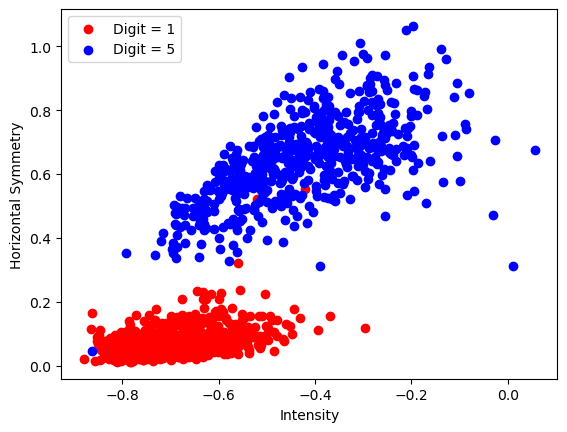

In [4]:
plt.scatter(intensities_dig1, symmetry_dig1, c="red", label="Digit = {}".format(dig1))
plt.scatter(intensities_dig2, symmetry_dig2, c="blue", label="Digit = {}".format(dig2))

plt.xlabel("Intensity")
plt.ylabel("Horizontal Symmetry")
plt.legend()
plt.show()

In [5]:
data = pd.DataFrame(df_train.iloc[:,:3])
data_train = data
y = pd.DataFrame(df_train.iloc[:,3]).to_numpy()

Part 1: Implementing Forward and Backward Propagation

In [6]:
def forwardProp(x0, w_forward):
    global number_of_layers
    s_forward = {}
    x_forward = {}
    x_forward[0] = x0

    for i in range(1,number_of_layers+1,1):
        s = np.dot(np.transpose(w_forward[i]), x_forward[i-1])
        s_forward[i] = s
        x_forward[i] = np.append(np.array([1]), np.array(np.tanh(s)))
        x_forward[i] = x_forward[i].reshape(-1, 1)
        
    return x_forward, s_forward, w_forward

In [7]:
def backwardProp(x_forward, s_forward, w_forward, y, k):
    global number_of_layers
    
    x_backward = copy.deepcopy(x_forward)
    w_backward = copy.deepcopy(w_forward)
    s_backward = copy.deepcopy(s_forward)

    for i in range(len(x_backward)):
        x_backward[i] = x_backward[i][1:]

    for i in range(1,len(w_backward)+1,1):
        w_backward[i] = w_backward[i][1:]
    
    delta_backward = {}
    delta_backward[2] = 2*(x_backward[2]-y[k])*(1-(np.tanh(s_backward[2])**2))
    
    for i in range(number_of_layers-1, 0, -1):
        tanh_deri = 1-(np.tanh(s_backward[i])**2)
        delta_backward[i] = np.multiply(tanh_deri, (w_backward[i+1] * delta_backward[i+1]))
    
    return delta_backward

Part 2: Implementing Stochastic Gradient Descent

In [8]:
def gradientDescent(x_forward, delta_backward, N):
    global number_of_layers    
    grad_des = {}
    
    for i in range(1,number_of_layers+1,1):
        grad_des[i] = np.matmul(x_forward[i-1], delta_backward[i].T)
    
    return grad_des

In [9]:
def batchGradientDescent(x_forward, delta_backward, N):
    global number_of_layers    
    grad_des = {}
    
    for i in range(1,number_of_layers+1,1):
        grad_des[i] = np.matmul(x_forward[i-1], delta_backward[i].T)
        grad_des[i] = grad_des[i] + 1/N*grad_des[i]
    
    return grad_des

In [10]:
def updateWeights(w_forward, grad_des, learn_rate):
    for i in range(len(w_forward)):
        w_forward[i+1] = w_forward[i+1] - learn_rate*grad_des[i+1]
    
    return w_forward

Part 3: Training the network for 1281 epochs.

In [11]:
x = data.to_numpy()
number_of_layers = 2
num_hidden_units = 2
learn_rate = 0.5

np.random.seed(1)
w_forward = {}
w_forward[1] = np.random.randn(x.shape[1], num_hidden_units)
w_forward[2] = np.random.randn(num_hidden_units+1, 1)
e_in_arr = []
epochs = 1281

for j in range(epochs):
    e_in = 0
    permutation = np.random.permutation(x.shape[0])
    x_shuf = x[permutation]
    y_shuf = y[permutation]
    
    for i in range(len(x_shuf)):
        x0 = x_shuf[i, :].reshape(-1, 1)
        x_forward, s_forward, w_forward = forwardProp(x0, w_forward)
        
        delta_backward = backwardProp(x_forward, s_forward, w_forward, y_shuf, i)

        N = len(x)
        e_in = e_in + 1/N*((x_forward[number_of_layers][1:] - y_shuf[i])**2)

        grad_des = gradientDescent(x_forward, delta_backward, N)
        w_forward = updateWeights(w_forward, grad_des, learn_rate)
        
    e_in_arr.append(e_in[0]) 

Part 4: Below is the graph of in sample error.

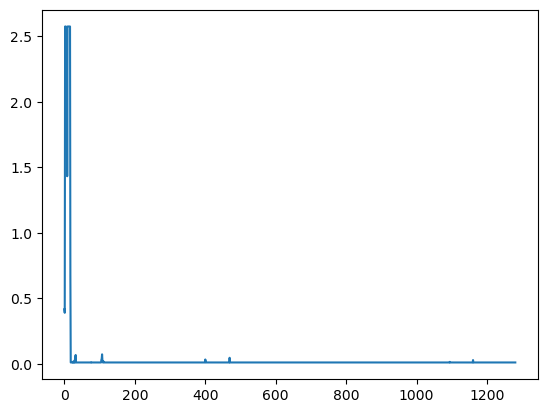

In [12]:
plt.plot(e_in_arr)

In [13]:
intensities_dig1 = []
intensities_dig2 = []
symmetry_dig1 = []
symmetry_dig2 = []
intensities = []
symmetry = []
y = [] 

for i in range(df_test.shape[0]):
        pix = np.array(df_test.iloc()[i])
        avg = np.mean(pix[1:]) 
        arr = np.array(pix[1:])
        image_2d = arr.reshape(16, 16)
        upper_half = image_2d[:8,:]
        lower_half = image_2d[8:,:]
        lower_half_flipped = np.flipud(lower_half)
        avg1 = np.mean(np.absolute(upper_half - lower_half_flipped))
        intensities.append(avg)
        symmetry.append(avg1)
        if(df_test[0][i]==1):
            intensities_dig1.append(avg)
            symmetry_dig1.append(avg1)
            y.append(1)
        else:
            intensities_dig2.append(avg)
            symmetry_dig2.append(avg1)
            y.append(-1)
        
labels = np.where(df_test[0]==1, "red", "blue")
df_test.insert(0,"Labels",labels)
df_test.insert(0,"y",y)
df_test.insert(0,"x2",symmetry)
df_test.insert(0,"x1",intensities)
df_test.insert(0,"x0",[1]*df_test.shape[0])

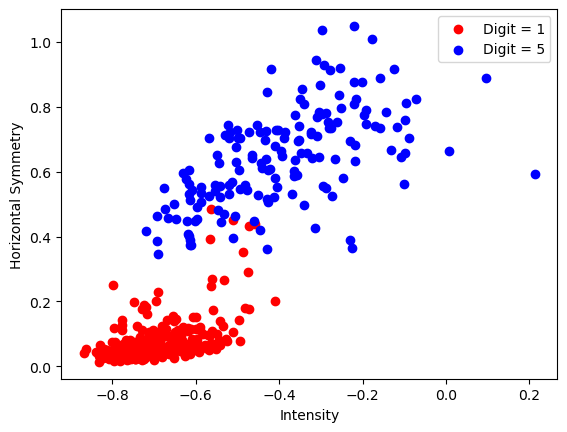

In [14]:
plt.scatter(intensities_dig1, symmetry_dig1, c="red", label="Digit = {}".format(dig1))
plt.scatter(intensities_dig2, symmetry_dig2, c="blue", label="Digit = {}".format(dig2))

plt.xlabel("Intensity")
plt.ylabel("Horizontal Symmetry")
plt.legend()
plt.show()

Part 4: Reporting the test error. 

In [15]:
x_test = pd.DataFrame(df_test.iloc[:,:3]).to_numpy()
y_test = pd.DataFrame(df_test.iloc[:,3]).to_numpy()

In [16]:
number_of_layers = 2
num_hidden_units = 2
learn_rate = 1
count = 0

np.random.seed(40)
for i in range(len(x_test)):
    x0 = x_test[i, :].reshape(-1, 1)
    x_forward, s_forward, w_forward = forwardProp(x0, w_forward)
    hx = x_forward[2][1][0]
    
    if(np.sign(hx)==np.sign(y_test[i])):
        count+=1
        
print("Accuracy:", str(100*count/len(y_test))+'%')



Accuracy: 97.87735849056604%


HP 2: Using 32 samples in a single epoch. Training the network for 1000 epochs.

In [17]:
x = data.to_numpy()
y = pd.DataFrame(df_train.iloc[:,3]).to_numpy()
number_of_layers = 2
num_hidden_units = 2
learn_rate = 0.1

np.random.seed(1)
w_forward = {}
w_forward[1] = np.random.randn(num_hidden_units, x.shape[1]).reshape(-1, 2)
w_forward[2] = np.random.randn(1, num_hidden_units+1).reshape(-1, 1)
e_in_arr = []
epochs = 1000
N = 32

total_grad = {}
for i in range(1,number_of_layers+1,1):
    total_grad[i] = 0

for j in range(epochs):
    e_in = 0
    
    total_grad = {}
    for i in range(1,number_of_layers+1,1):
        total_grad[i] = 0
    permutation = np.random.permutation(x.shape[0])
    x_shuf = x[permutation]
    y_shuf = y[permutation]
    
    for i in range(32):
        x0 = x_shuf[i, :].reshape(-1, 1)
        x_forward, s_forward, w_forward = forwardProp(x0, w_forward)
        
        delta_backward = backwardProp(x_forward, s_forward, w_forward, y_shuf, i)
        
        e_in = e_in + 1/N*(x_forward[number_of_layers][1:] - y_shuf[i])**2

        grad_des = batchGradientDescent(x_forward, delta_backward, N)
        
        for k in range(1,number_of_layers+1,1):
            total_grad[k] = total_grad[k] + (1/N*grad_des[k])
    
#         print(i,"GRad", grad_des)
#         print(i, "total", total_grad)
    w_forward = updateWeights(w_forward, total_grad, learn_rate)
        
#     print("In Sample Error", e_in)
    e_in_arr.append(e_in[0]) 

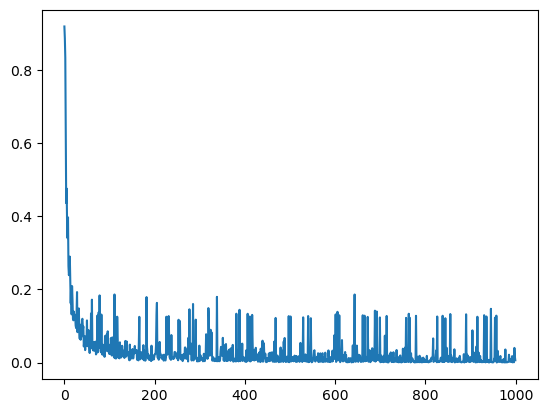

In [18]:
plt.plot(e_in_arr)

In [19]:
x_test = pd.DataFrame(df_test.iloc[:,:3]).to_numpy()
y_test = pd.DataFrame(df_test.iloc[:,3]).to_numpy()

In [20]:
number_of_layers = 2
num_hidden_units = 2
learn_rate = 1
count = 0

np.random.seed(40)
for i in range(len(x_test)):
    x0 = x_test[i, :].reshape(-1, 1)
    x_forward, s_forward, w_forward = forwardProp(x0, w_forward)
    hx = x_forward[2][1][0]
    
    if(np.sign(hx)==np.sign(y_test[i])):
        count+=1
        
print("Accuracy:", str(100*count/len(y_test))+'%')

Accuracy: 98.34905660377359%
